<a href="https://colab.research.google.com/github/Mohamed-Diagne/Option-Pricing-and-Hedging-Strategies/blob/main/Option_Pricing_and_Hedging_Strategies_Black_Scholes%2C_Monte_Carlo%2C_Local_Volatility%2C_and_Greeks_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Option Pricing and Hedging Strategies: Black-Scholes, Monte Carlo, Local Volatility, and Greeks Analysis**

---
📌 **Introduction**

This project explores **option pricing and risk management** using the Black-Scholes model, applied to **Puig**, the Spanish luxury and cosmetics company.  
As the largest IPO in Europe in 2024, Puig raised €2.74 billion in its stock market debut, making it a prime case study for **option valuation**, **Greeks analysis**, and **implied volatility**.

The project further extends to **stochastic processes**, including **Geometric Brownian Motion**, the **Binomial Model**, and **Local Volatility**, to better capture market dynamics.

Finally, we implement **hedging strategies** (delta, gamma, vega, and theta neutral) to explore how derivatives can be used to **manage portfolio risk** in real-world scenarios.


# Choice of stock and the parameter

- **Maturity:** **T=3 months**. This choice ensures a realistic market representation, as this maturity accounts for more than 30% of the traded volume according to the AMF (Le Moign & Ezra, 2021).
- **Risk-Free:** **EURIBOR 3 Months**. EURIBOR is the standard benchmark for short-term risk-free rates in the Eurozone.
- **Annualized volatility: SMA method**. We used the log-returns log-returns as they best approximate continuous time, being compatible with the GBM model. We then compute volatility using the SMA method on the standard deviation of log-returns over the three months preceding the pricing.

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [ ]:
# Download Puig's stock data
ticker = "PUIG.MC"
data = yf.download(ticker, period="max")

# Keep only the 'Close' column
data = data[['Close']]
data.index = pd.to_datetime(data.index)

# Filter data up to March 17, 2025
data = data[data.index <= '2025-03-17']

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Compute logarithmic returns
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
# Select the last 63 observations (3 months equal to 63 days trading)
last_32 = data['Log_Return'].dropna().tail(63)
# Compute the SMA volatility
volatility_SMA = np.std(last_32, ddof=0)  # ddof=0 for population standard deviation
# Annualize the volatility
annualized_volatility_SMA = volatility_SMA * np.sqrt(252)
print("Annualized Volatility SMA:", annualized_volatility_SMA)


Annualized Volatility SMA: 0.291481138875554


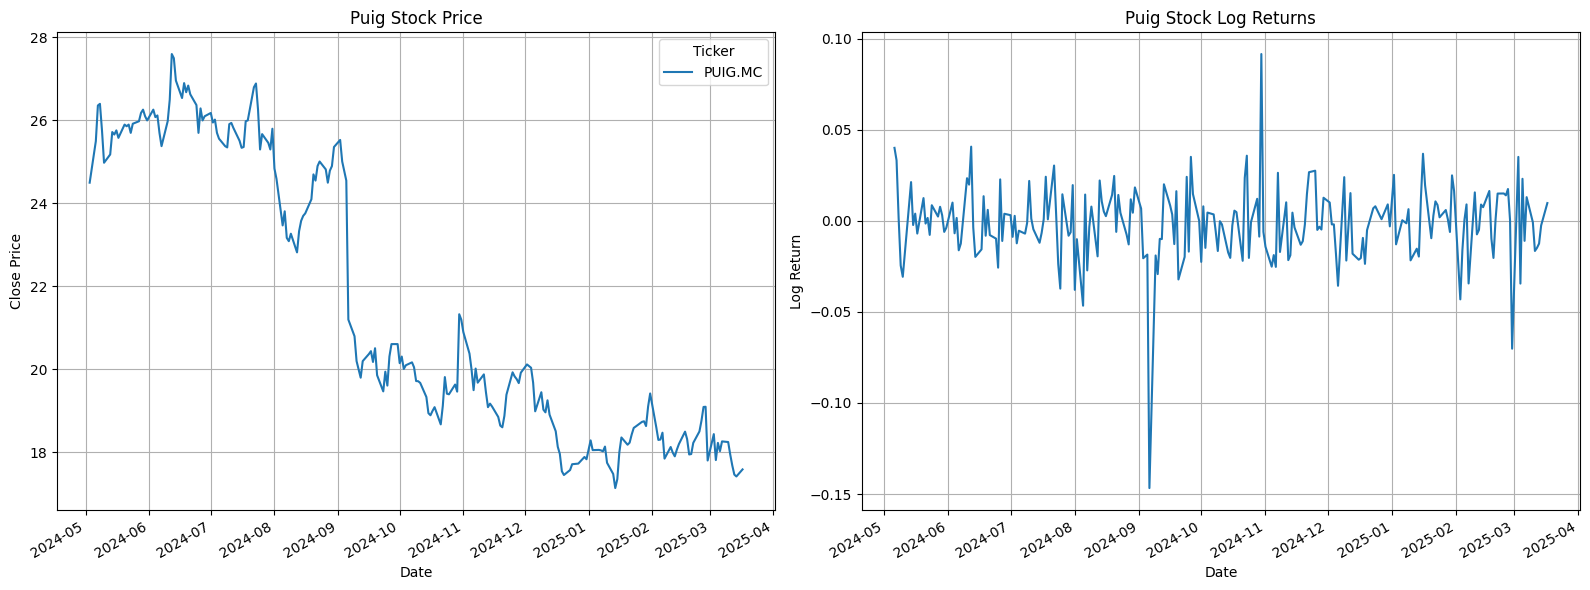

In [ ]:
# Create a figure and two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Close Price on the left subplot
data['Close'].plot(ax=axes[0])
axes[0].set_title('Puig Stock Price')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Close Price')
axes[0].grid(True)

# Plot Log Returns on the right subplot
data['Log_Return'].plot(ax=axes[1])
axes[1].set_title('Puig Stock Log Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Log Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

plt.show()


For the Risk-Free, we take the last observation of the Value because we supposed that the last observation (2025-03-17) is the best observation (source of the data : Eurobior-rates)

In [ ]:
euribor= 0.02478

# Black and Scholes


The Black-Scholes model is a mathematical framework for pricing European-style options. It was developed by Fischer Black and Myron Scholes in 1973 and later extended by Robert Merton. The model provides a closed-form solution for the fair price of an option based on key variables such as the stock price, strike price, time to expiration, volatility, risk-free interest rate, and dividends. The fundamental idea behind the model is that an option can be perfectly replicated and hedged using a continuously adjusted portfolio of the underlying asset and a risk-free bond

**Assumptions of the Black-Scholes Model**


* **The underlying asset follows a geometric Brownian motion**: The price of the asset evolves continuously and follows a stochastic process with constant drift and volatility.
* **The volatility of the underlying asset is constant**:
* **Risk-free borrowing and lending at a constant, known rate r:** Investors can borrow and lend unlimited amounts at the risk-free rate, which is assumed to be constant and continuously compounded. The price of a zero-coupon bond follows the equation: dD(t) = rD(t)dt.
* **No dividends or cash flows during the option's life**: The original Black-Scholes model assumes no dividend payments, though it can be adjusted for known dividend yields.
* **No transaction costs or taxes**: There are no fees or frictions when buying or selling the underlying asset or the option.
* **Continuous trading and perfect liquidity**: The market allows for continuous buying and selling without restrictions.
* **No arbitrage opportunities**: The price of the option reflects fair value, and no risk-free profit can be made.
* **European-style options only**: The model applies only to options that can be exercised at expiration, not to American-style options that can be exercised at any time.
* **The price of the underlying asset follows a lognormal distribution**: The price of the underlying asset follows a lognormal distribution Asset prices cannot be negative.




In [ ]:
def black_scholes_call(S, K, T, r, sigma):
    """Calculates the theoretical price of a European call option using the Black-Scholes model.

    Args:
        S: Current stock price.
        K: Strike price.
        T: Time to maturity (in years).
        r: Risk-free interest rate (annualized).
        sigma: Volatility of the underlying asset (annualized).

    Returns:
        The theoretical price of the European call option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def put_price_parity(S, K, T, r, call_price):
    """Calculates the put price using put-call parity.

    Args:
        S: Current stock price.
        K: Strike price.
        T: Time to maturity (in years).
        r: Risk-free interest rate (annualized).
        call_price: The price of the corresponding call option.

    Returns:
        The theoretical price of the European put option.
    """
    put_price = call_price - S + K * np.exp(-r * T)
    return put_price

**Summary of Model Inputs**

In [ ]:
K= np.mean(data['Close'].tail(63))
#We used the mean of the last 3 months (~63 trading days) to estimate the Strike Price (K), reflecting the recent price trend as the stock's movement has changed.
T=3/12
r=euribor
sigma=annualized_volatility_SMA
S = float(data['Close'].iloc[-1])   # The last value
print(f"The strike price (K) is: {K}")
print(f"The underlying price (S) is: {S}")
print(f"The annualized volatility (sigma) is: {sigma}")
print(f"The time to maturity (T) is: {T}")
print(f"The risk-free rate (r) is: {r}")


The strike price (K) is: 18.142460293240017
The underlying price (S) is: 17.59000015258789
The annualized volatility (sigma) is: 0.291481138875554
The time to maturity (T) is: 0.25
The risk-free rate (r) is: 0.02478


<ipython-input-174-edcaae73a928>:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S = float(data['Close'].iloc[-1])   # The last value


**Calculation of Option Premiums**

In [ ]:
call_premium=black_scholes_call(S, K, T, r, sigma)
print("Call:", call_premium)

Call: 0.829230464724616


**Put Premium via Put-Call Parity**

In [ ]:
put_premium=put_price_parity(S, K, T, r,call_premium)
print("Put:", put_premium)

Put: 1.2696454819688618


The put option premium is higher than the call option price, which is consistent given that the strike price (K) is higher than the current stock price (Sₜ).

**Payoff and P&L Calculation**

The payoff of a **call option** at expiration is given by:  
-  $ \ \text{Payoff} = \max(S_T - K, 0 ) $ .

The P&L profit takes into account the initial premium paid:  
-  $ \ P\&L = \max(S_T - K, 0) - C_0 $.

In [ ]:
call_payoff = np.maximum(S - K, 0)
pnl_call = call_payoff - call_premium
print("Call Payoff:", call_payoff)
print("P&L Call:", pnl_call)

Call Payoff: 0.0
P&L Call: -0.829230464724616


The call payoff of 0 indicates the option is out-of-the-money (since
𝑆
<
𝐾
S<K) and has no intrinsic value at expiration. Consequently, the net P&L of -0.83 shows a loss equal to the premium paid for the call.

The payoff  of a put option at expiration is given by:
- $ \text{Payoff} = \max(K - S_T, 0) $.

The P&L profit takes into account the initial premium paid:
- $ P\&L = \max(K - S_T, 0) - P_0 $.



In [ ]:
payoff_put = np.maximum(K - S, 0)  # Put payoff function
pnl_put = payoff_put - put_premium  # Profit & Loss calculation
print("Put Payoff:", payoff_put)
print("P&L Put:", pnl_put)

Put Payoff: 0.5524601406521263
P&L Put: -0.7171853413167355


The put payoff of 0.55 reflects the intrinsic value (since K > S). However, subtracting the 1.27 premium leads to a net loss of -0.72, indicating the stock price hasn’t fallen enough to cover the option’s cost.



# The Greeks

The **Greeks** are a set of sensitivity measures that describe how an option’s price reacts to changes in various market variables. The most commonly used Greeks are **Delta, Gamma, Theta, Vega, and Rho**.

---

### **1 Delta** – Sensitivity to Price Changes  
Delta measures the rate of change of an option’s price with respect to the price of the underlying asset.

$$
\Delta = \frac{\partial C}{\partial S} = N(d_1)
$$

For a **put option**:

$$
\Delta_{\text{put}} = N(d_1) - 1
$$

where:

$$
d_1 = \frac{\ln(S / K) + (r + \sigma^2 / 2) T}{\sigma \sqrt{T}}
$$

---

### **2 Gamma** – Sensitivity of Delta to Price Changes  
Gamma measures the rate of change of **Delta** with respect to the underlying asset price.

$$
\Gamma = \frac{\partial^2 C}{\partial S^2} = \frac{N'(d_1)}{S \sigma \sqrt{T}}
$$

- **Gamma is the same for calls and puts**.
- **ATM (At-The-Money) options** have the **highest gamma**.
- **Deep ITM or OTM options** have a **low gamma**.

**Interpretation**:  
- If Gamma is high, **Delta changes rapidly**, making the option riskier.

---

### **3 Theta** – Sensitivity to Time Decay  
Theta measures the rate of change of an option’s price concerning the **passage of time**.

For a **call option**:

$$
\Theta_{\text{call}} = -\frac{S N'(d_1) \sigma}{2\sqrt{T}} - rK e^{-rT} N(d_2)
$$

For a **put option**:

$$
\Theta_{\text{put}} = -\frac{S N'(d_1) \sigma}{2\sqrt{T}} + rK e^{-rT} N(-d_2)
$$

- Theta is **negative** for long options, meaning the option **loses value over time**.
- ATM options have the **highest absolute Theta**.
- **As expiration approaches**, Theta decay accelerates.

---

### **4 Vega** – Sensitivity to Volatility Changes  
Vega measures how an option’s price changes with respect to changes in the underlying asset’s **volatility**.

$$
\nu = \frac{\partial C}{\partial \sigma} = S \sqrt{T} N'(d_1)
$$

- **Higher Vega means the option is more sensitive to volatility changes**.
- ATM options have the **highest Vega**.
- Vega **decreases** as the option approaches expiration.

---

### **5 Rho** – Sensitivity to Interest Rate Changes  
Rho measures how an option’s price changes with respect to **interest rate movements**.

For a **call option**:

$$
\rho_{\text{call}} = K T e^{-rT} N(d_2)
$$

For a **put option**:

$$
\rho_{\text{put}} = -K T e^{-rT} N(-d_2)
$$

- **For call options**: Rho is **positive** (higher rates increase call value).
- **For put options**: Rho is **negative** (higher rates decrease put value).
- **Long-term options** have **higher Rho sensitivity**.


In [ ]:
def black_scholes_greeks_call(S, K, T, r, sigma):
    """
    Computes the Greeks for a European Call option using the Black-Scholes model.

    :param S: Current stock price
    :param K: Strike price
    :param T: Time to maturity (in years)
    :param r: Risk-free interest rate (as a decimal)
    :param sigma: Volatility of the underlying asset (as a decimal)
    :return: Dictionary containing Delta, Gamma, Theta, Vega, and Rho
    """
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Compute the Greeks
    delta = norm.cdf(d1)  # Delta for a Call option
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))  # Gamma
    theta = (- (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
             - r * K * np.exp(-r * T) * norm.cdf(d2)) / 365  # Theta (per day)
    vega = (S * norm.pdf(d1) * np.sqrt(T)) / 100  # Vega (per 1% volatility change)
    rho = (K * T * np.exp(-r * T) * norm.cdf(d2)) / 100  # Rho (per 1% interest rate change)

    # Calculate the impact of the assumed changes
    delta_C_vega = vega * 1.7  # Change in price due to a 1.7% increase in volatility
    delta_C_rho = rho * 3.2  # Change in price due to a 3.2% increase in risk-free rate

    # Return the results as a dictionary
    return {
        "Delta": delta,
        "Gamma": gamma,
        "Theta (daily)": theta,
        "Vega": vega,
        "Rho": rho,
        "Impact of +1.7% Volatility on Call Price": delta_C_vega,
        "Impact of +3.2% Risk-Free Rate on Call Price": delta_C_rho
    }

**Calculation of Greeks – Call Option**

In [ ]:
# Compute the Greeks for a Call option
call_greeks = black_scholes_greeks_call(S, K, T, r, sigma)

# Display the results
print(" Greeks and Sensitivity Analysis for the Call Option:")
for greek, value in call_greeks.items():
    print(f"{greek}: {value:.6f}")

 Greeks and Sensitivity Analysis for the Call Option:
Delta: 0.461438
Gamma: 0.154892
Theta (daily): -0.006072
Vega: 0.034923
Rho: 0.018219
Impact of +1.7% Volatility on Call Price: 0.059369
Impact of +3.2% Risk-Free Rate on Call Price: 0.058300


# Analysis of Greeks and Option Sensitivity

The computed Greeks indicate that the option is near ATM (*At-The-Money*) with a 3-month expiration.

### Details of the Greeks

- **Delta (0.461)**  
  If Puig stock price increases by €1, the option's price will increase by approximately €0.461, reflecting the delta sensitivity of the position. Additionally, the delta value of 0.461 indicates that the option has approximately a 46.1% probability of expiring in-the-money.

- **Gamma (0.155)**  
  If Puig stock increases by 1%, the delta of the option will increase by 0.155, which indicates a relatively high gamma sensitivity. This means the option's delta adjusts significantly with even small movements in the underlying asset price.

- **Theta (-0.0061 per day)**  
  Reflects daily time decay, meaning the option loses about $0.0061 in value each day.

- **Vega (0.0349)**  
  If implied volatility increases by 1 percentage point, the option's price will increase by approximately €0.0349, indicating moderate sensitivity to volatility changes in the underlying asset.

- **Rho (0.0182)**  
  If interest rates increase by 1 percentage point, the option's price will increase by approximately €0.0182, showing relatively low sensitivity to interest rate changes.

### Sensitivity Analysis

- A **+1.7%** increase in volatility raises the call price by **0.0594**.
- A **+3.2%** increase in interest rates raises the call price by **$0.0583**.


*Overall, these results confirm that the option, being near ATM, is highly sensitive to changes in the underlying price, volatility, and interest rates.*


# Implied Volatility

**Definition**

Implied volatility (IV) is an estimate of an asset’s future volatility, reflecting the market's consensus on how much the price of the asset is expected to fluctuate. It is the volatility value that, when used in the Black-Scholes model, results in the observed market price of an option. In other words, IV is the volatility level that equates the theoretical option price to the actual market price.

IV is driven by market expectations and is influenced by factors such as:
- Investor sentiment
- Macroeconomic conditions
- Supply-demand imbalances in the options market

Since there is no closed-form solution to directly compute IV from the Black-Scholes formula, numerical methods like the Newton-Raphson method or the Bisection method are used to iteratively adjust volatility until the theoretical option price matches the observed market price.

## Newton-Raphson Method for Implied Volatility

Since IV is not directly solvable, we use an iterative approach to estimate it. The Newton-Raphson method adjusts **σ** (volatility) step by step until the Black-Scholes price matches the market price of the option.

The iterative formula is:

$$
\sigma_{n+1} = \sigma_n - \frac{f(\sigma_n)}{f'(\sigma_n)}
$$

Where:

- **f(σₙ)** = V<sub>BS</sub>(σₙ) − V<sub>market</sub>  
  This is the difference between the calculated Black-Scholes price and the observed market price.

- **f′(σₙ)** is the **vega** of the option, given by:

$$
f'(\sigma_n) = S_0 \, N'(d_1) \sqrt{T}
$$

We reuse the previously defined Vega function to ensure consistency.



In [ ]:
# Newton-Raphson method for implied volatility
def implied_volatility(option_price, S, K, T, r, option_type="call", tol=1e-6, max_iter=100):

    sigma = 0.2  # Initial guess for volatility

    for _ in range(max_iter):
        if option_type == "call":
            price = black_scholes_call(S, K, T, r, sigma)
        else:
            price = put_price_parity(S, K, T, r, black_scholes_call(S, K, T, r, sigma))

        diff = price - option_price  # Difference between calculated and market price
        vega = black_scholes_greeks_call(S, K, T, r, sigma)["Vega"] * 100  # Use previously computed Vega

        if abs(diff) < tol:  # Stop if close enough
            return sigma

        sigma -= diff / vega  # Newton-Raphson update

    return np.nan  # Return NaN if not converging

# Assume market prices for options (either real data or 30% deviation from theoretical price)
market_call_price = 1.3 * black_scholes_call(S, K, T, r, sigma)
market_put_price = 1.3 * put_price_parity(S, K, T, r, market_call_price)

# Compute implied volatility for call and put
iv_call = implied_volatility(market_call_price, S, K, T, r, "call")
iv_put = implied_volatility(market_put_price, S, K, T, r, "put")

# Display results
print(f"Implied Volatility (Call): {iv_call:.6f}")
print(f"Implied Volatility (Put): {iv_put:.6f}")


Implied Volatility (Call): 0.362564
Implied Volatility (Put): 0.492422


📊 **Interpretation**  
The implied volatility of the **call** is **36.26%**, while the **put** shows a higher value of **49.24%**,  
indicating a **volatility skew** and suggesting that the market anticipates **downside risk** or shows **stronger demand for puts**.


# **Stochastic Processes in Finance**

## **1. Standard Brownian Motion ($W_t$)**

A **Brownian motion** $W_t$ is a continuous-time stochastic process used to model **random uncertainty** in financial markets. It satisfies the following properties:

1. $W_0 = 0$
2. $W_t - W_s \sim \mathcal{N}(0, t - s)$ for $t > s$
3. Increments are **independent and stationary**
4. Paths are **continuous** but **nowhere differentiable**

---

## **2. Geometric Brownian Motion (GBM)**

In finance, asset prices are typically modeled by a **Geometric Brownian Motion**, which incorporates both **expected growth** (drift) and **randomness** (volatility).  

It is defined by the stochastic differential equation (SDE):

$$
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t
$$

### **Where:**
- $S_t$: asset price at time $t$  
- $\mu$: drift (expected return)  
- $\sigma$: volatility  
- $W_t$: standard Brownian motion  

---

## **Closed-form Solution of GBM**

The solution to the SDE is:

$$
S_t = S_0 \cdot \exp \left( \left( \mu - \frac{\sigma^2}{2} \right) t + \sigma W_t \right)
$$

This allows for simulation and analytical computations of asset paths under GBM.

---

## **Key Properties of Geometric Brownian Motion**

1. **Log-normal distribution**: $S_t$ is strictly positive and log-normally distributed  
   - Mean:  
     $$
     \mathbb{E}[S_t] = S_0 \cdot \exp(\mu t)
     $$
   - Variance:  
     $$
     \text{Var}[S_t] = S_0^2 \cdot \exp(2\mu t) \cdot \left( \exp(\sigma^2 t) - 1 \right)
     $$

2. **Positivity**: $S_t > 0$ for all $t$, unlike standard Brownian motion

3. **Markov property**: Future evolution depends only on current value $S_t$

4. **Continuous paths**: Price paths are continuous, without jumps

5. **Proportional returns**: Changes in price are proportional to current price

6. **Independent log-returns**: Over non-overlapping intervals, log-returns are independent

---

📌 GBM is the **core assumption** behind the **Black-Scholes model**, and a cornerstone in modern financial modeling.


<br>

 ## **Monte Carlo Simulation under Risk-Neutral Measure (Constant Volatility)**

We use the **risk-free rate** \( r \) as the drift because, under the **risk-neutral measure**, expected returns are replaced by \( r \) to ensure no-arbitrage pricing.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def monte_carlo_call_option(S, K, r, sigma, T, num_simulations=11000, num_steps=63, seed=None):
    """
    Monte Carlo simulation for European call option pricing using GBM under risk-neutral framework.

    Parameters:
    - S : float : Current asset price
    - K : float : Strike price
    - r : float : Risk-free interest rate
    - sigma : float : Annualized volatility
    - T : float : Time to maturity (in years)
    - num_simulations : int : Number of simulated paths
    - num_steps : int : Number of time steps in each path
    - seed : int or None : Optional random seed for reproducibility

    Returns:
    - call_price : Estimated option price
    - confidence_interval : 95% confidence interval for the price
    - final_prices : Array of final asset prices
    - price_paths : Array of sample simulated paths
    """
    if seed is not None:
        np.random.seed(seed)

    dt = T / num_steps
    final_prices = np.zeros(num_simulations)

    num_paths_to_plot = 100
    price_paths = np.zeros((min(num_paths_to_plot, num_simulations), num_steps + 1))
    price_paths[:, 0] = S

    for i in range(num_simulations):
        Z = np.random.normal(0, 1, num_steps)
        S_curr = S
        for t in range(num_steps):
            S_curr *= np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t])
            if i < num_paths_to_plot:
                price_paths[i, t+1] = S_curr
        final_prices[i] = S_curr

    payoffs = np.maximum(final_prices - K, 0)
    discounted_payoffs = np.exp(-r * T) * payoffs
    call_price = np.mean(discounted_payoffs)

    std_error = np.std(discounted_payoffs) / np.sqrt(num_simulations)
    confidence_interval = (call_price - 1.96 * std_error, call_price + 1.96 * std_error)

    return call_price, confidence_interval, final_prices, price_paths


# === Example usage ===
# Assumes S, K, r, sigma, T are defined in your notebook already
call_price, confidence_interval, final_prices, price_paths = monte_carlo_call_option(
    S, K, r, sigma, T, num_simulations=11000, seed=42
)

# === Output ===
print(f"Monte Carlo Call Option Pricing Results:")
print(f"Number of simulations: 11,000")
print(f"Current asset price (S): ${S:.2f}")
print(f"Strike price (K): ${K:.2f}")
print(f"Risk-free rate (Euribor): {r*100:.2f}%")
print(f"Volatility (annualized_volatility_SMA): {sigma*100:.2f}%")
print(f"Time to maturity: {T*12:.0f} months")
print(f"Call option price: ${call_price:.4f}")
print(f"95% Confidence interval: (${confidence_interval[0]:.4f}, ${confidence_interval[1]:.4f})")


Monte Carlo Call Option Pricing Results:
Number of simulations: 11,000
Current asset price (S): $17.59
Strike price (K): $18.14
Risk-free rate (Euribor): 2.48%
Volatility (annualized_volatility_SMA): 29.15%
Time to maturity: 3 months
Call option price: $0.8156
95% Confidence interval: ($0.7881, $0.8430)


The estimated price of the call option is **$0.8156**, based on **11,000** Monte Carlo simulations.  
The 95% confidence interval indicates that the estimate is statistically reliable, even though the current asset price ( S = 17.59) is slightly below the strike price ( K = 18.14 ).


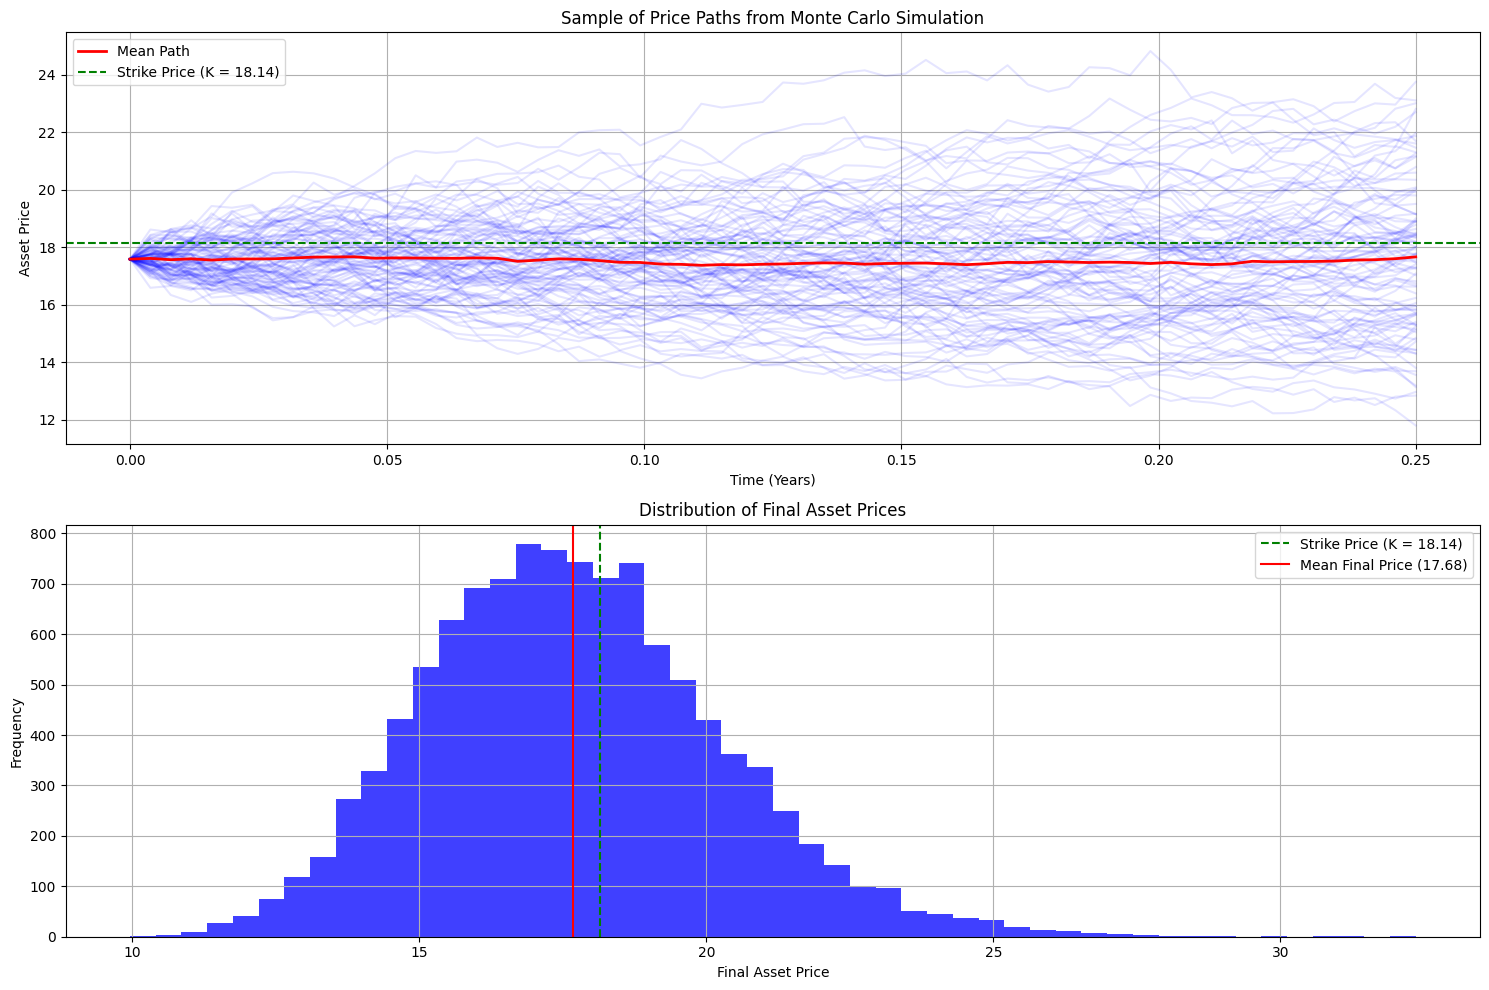

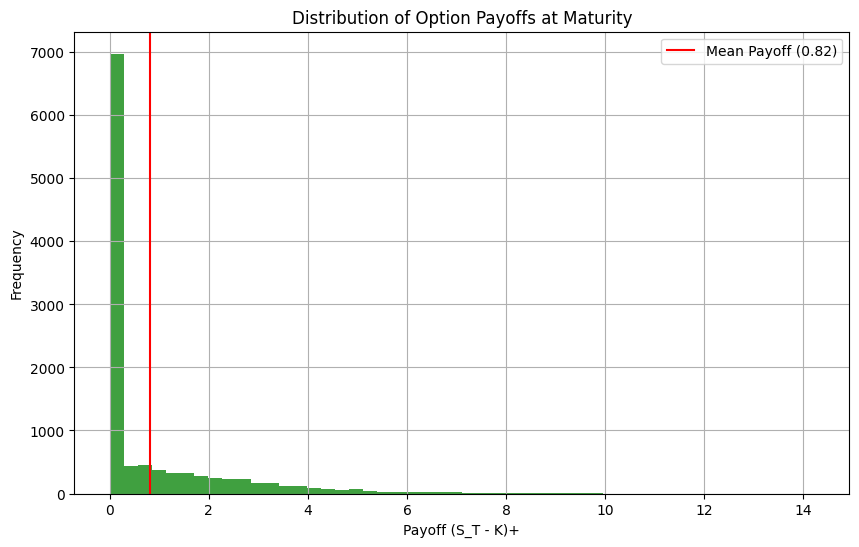

In [ ]:
# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Sample price paths
plt.subplot(2, 1, 1)
time_points = np.linspace(0, T, price_paths.shape[1])
for i in range(price_paths.shape[0]):
    plt.plot(time_points, price_paths[i], 'b-', alpha=0.1)
plt.plot(time_points, np.mean(price_paths, axis=0), 'r-', linewidth=2, label='Mean Path')
plt.axhline(y=K, color='g', linestyle='--', label=f'Strike Price (K = {K:.2f})')
plt.title('Sample of Price Paths from Monte Carlo Simulation')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price')
plt.legend()
plt.grid(True)

# Plot 2: Histogram of final prices
plt.subplot(2, 1, 2)
plt.hist(final_prices, bins=50, alpha=0.75, color='blue')
plt.axvline(x=K, color='g', linestyle='--', label=f'Strike Price (K = {K:.2f})')
plt.axvline(x=np.mean(final_prices), color='r', linestyle='-', label=f'Mean Final Price ({np.mean(final_prices):.2f})')
plt.title('Distribution of Final Asset Prices')
plt.xlabel('Final Asset Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot payoff distribution
plt.figure(figsize=(10, 6))
payoffs = np.maximum(final_prices - K, 0)
plt.hist(payoffs, bins=50, alpha=0.75, color='green')
plt.axvline(x=np.mean(payoffs), color='r', linestyle='-', label=f'Mean Payoff ({np.mean(payoffs):.2f})')
plt.title('Distribution of Option Payoffs at Maturity')
plt.xlabel('Payoff (S_T - K)+')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

The simulated asset price paths show high dispersion, with the mean path remaining below the strike price.  
The histogram confirms that most final prices end below the strike \( K = 18.14 \), which limits the expected payoff of the call option.


<br>


## **Local Volatility process**

Local volatility is the concept that the instantaneous volatility of an asset is not constant but depends on both the asset's current price and time. It is denoted as ds`(σ(t, S_t))`, representing the volatility at a specific price level \(S_t\) and time \(t\).

Unlike the constant volatility assumed in the classic Geometric Brownian Motion (GBM) model, local volatility adjusts according to the current asset price and time.

Local volatility models help explain why implied volatilities differ across strike prices, giving rise to phenomena such as the volatility smile and skew.

The local volatility process extends the GBM framework by replacing the constant volatility with a function that varies with time and the asset price.

$$
dS_t = (r - q) S_t \, dt + \sigma(t, S_t) S_t \, dW_t,
$$

### Explanation of Terms
- `(S_t)`: Asset price at time `t`.
- `(r)`: Risk-free interest rate.
- `(q)`: Dividend yield.
- `(σ(t, S_t))`: Local volatility function, giving the instantaneous volatility based on time and the asset price.
- `(dW_t)`: Increment of a Wiener process (Brownian motion).
- `(dt)`: A small time increment.

## Estimating Local Volatility

The local volatility surface, sigma(t, S_t), can be derived from market option prices using the **Dupire formula**:

$$
\sigma_{\text{loc}}^2(K, T) = \frac{\frac{\partial V}{\partial T} + (r - q) K \frac{\partial V}{\partial K} + qV}{\frac{1}{2} K^2 \frac{\partial^2 V}{\partial K^2}},
$$

where:
- **\(K\)**: Option strike price.
- **\(T\)**: Option maturity.
- **\(V\)**: Option price as a function of \(K\) and \(T\).


Once the local volatility surface sigma(t, S_t) is determined, it can be used to simulate the asset price dynamics. Instead of using a constant volatility in the simulation (as in the GBM model), the local volatility model uses a volatility that changes with both time and the asset price, leading to more accurate pricing of options, particularly for those options where the implied volatility varies significantly with strike price.
(http://www.columbia.edu/~mh2078/ContinuousFE/LocalStochasticJumps.pdf)


<br>



## **Monte Carlo Simulation under Local Volatility Model**





In our implementation, we do not estimate the full local volatility surface, but rather approximate the dynamics by setting the drift to $\mu = r - q$, as is often done in simplified models.  
This approach reflects real-world dynamics while retaining a tractable simulation framework.



To ensure the stability and reproducibility of the local volatility estimation via Dupire's formula, we set a fixed random seed before each Monte Carlo simulation.  
This allows for consistent option pricing results and more reliable numerical derivatives.


In [ ]:
# === Dupire Local Volatility Estimation (Reproducible) ===

# Dividend yield (set to 0 if not applicable)
q = 0

# Increments for finite differences
dK = 0.5
dT = 0.05

# Set seed for reproducibility
np.random.seed(42)

# Define surrounding strikes and maturities
K_plus = K + dK
K_minus = K - dK
T_plus = T + dT
T_minus = T - dT

# Extract only the call price from the output of your function (index [0])
V_KT     = monte_carlo_call_option(S, K, r, sigma, T)[0]
np.random.seed(42)
V_KpT    = monte_carlo_call_option(S, K_plus, r, sigma, T)[0]
np.random.seed(42)
V_KmT    = monte_carlo_call_option(S, K_minus, r, sigma, T)[0]
np.random.seed(42)
V_KTp    = monte_carlo_call_option(S, K, r, sigma, T_plus)[0]
np.random.seed(42)
V_KTm    = monte_carlo_call_option(S, K, r, sigma, T_minus)[0]

# Finite difference approximations
dV_dT = (V_KTp - V_KTm) / (2 * dT)
dV_dK = (V_KpT - V_KmT) / (2 * dK)
d2V_dK2 = (V_KpT - 2 * V_KT + V_KmT) / (dK ** 2)

# Dupire formula
numerator = dV_dT + (r - q) * K * dV_dK + q * V_KT
denominator = 0.5 * (K ** 2) * d2V_dK2
sigma_loc_squared = numerator / denominator

# Prevent sqrt of negative number
sigma_loc = np.sqrt(max(sigma_loc_squared, 0))

# Display result
print(f"Estimated local volatility at K = {K:.2f}, T = {T} years: {sigma_loc:.4f}")


Estimated local volatility at K = 18.14, T = 0.25 years: 0.2883


📉 **Interpretation**

The estimated **local volatility** at strike \( K = 18.14 \) is **28.83%**,  
which is significantly lower than the implied volatility of the **call (36.26%)** and especially the **put (49.24%)**.

This asymmetry reflects the market’s anticipation of **downside risk**, typically observed in the **volatility skew**,  
where puts trade at higher implied volatilities than calls due to stronger demand for downside protection.

In contrast, **local volatility** provides a **smoother, model-based estimate** that depends on both spot and time,  
and is less influenced by short-term market sentiment or order flow imbalances.

📌 This highlights the **limitations of constant-volatility models** like **Black-Scholes**  
in capturing real-world patterns such as **volatility smiles** and **skews**.




# Hedging

**Definition**  
Hedging is an investment practice aimed at offsetting or reducing the risk of adverse price movements in a financial asset. It typically involves taking an opposite or offsetting position in a correlated or negatively correlated asset.

### Why Use Hedging Strategies?
- **Risk Mitigation**: Protects against market (systematic) risk that cannot be diversified away.  
- **Preservation of Gains**: Locks in profits without fully exiting a position.  
- **Managing Exposure**: Limits potential losses from adverse price movements.

### Who Uses Hedging Strategies?
- **Individual Investors**: Seeking to safeguard gains or reduce exposure to a particular stock or asset.  
- **Institutions (e.g., Banks, Hedge Funds, Market Makers)**: Hedging large or continuous positions to limit risk from market fluctuations.

### Main Approaches
1. **Static Hedge**  
   - No rebalancing required after initial setup.

2. **Dynamic Hedge**  
   - Ongoing adjustments in response to market movements (e.g., delta hedging).

### Hedging in the Case of Options
- **Delta Hedging**: Neutralizes sensitivity to the underlying asset’s price.  
- **Gamma Hedging**: Offsets changes in delta over time.  
- **Vega Hedging**: Manages exposure to implied volatility.  
- **Theta Hedging**: Reduces the impact of time decay.


##**Delta**

- We implement the **Protective Put strategy** in light of recent market uncertainties, including new trade and tax policy risks stemming from Donald Trump's latest announcements. These factors raise the likelihood of short-term downside movements.  
Our objective is to limit potential losses while maintaining equity exposure. This decision is further supported by fundamental analysis (see the DeepResearch financial report in the notebook’s notes section).

- A Protective Put strategy involves holding a long position in the stock while simultaneously buying put options. This provides downside protection, as the puts increase in value if the stock price declines, effectively insuring the portfolio. However, this protection comes at the cost of the option premium paid.

In [ ]:
import numpy as np

def protective_put_hedge(stock_position, delta_put, contract_size=100):
    """
    Calculates the number of put option contracts required to hedge a stock position using a protective put strategy.

    :param stock_position: Number of shares held (positive for long)
    :param delta_put: Delta of the put option (typically negative)
    :param contract_size: Number of shares per option contract (default = 100)
    :return: Number of put contracts to buy (positive value)
    """
    num_put_contracts = -stock_position / (delta_put * contract_size)
    return num_put_contracts

# Given Data
stock_position = 15000             # Number of shares held
delta_put = call_greeks["Delta"] - 1   # Using put-call parity (Delta_put = Delta_call - 1)
contract_size = 100

# Calculate number of puts to buy
num_put_contracts = protective_put_hedge(stock_position, delta_put, contract_size)

# Display result
print(f"Protective Put Hedging Strategy:")
print(f"➡ To hedge your long stock position of {stock_position} shares, buy {num_put_contracts:.0f} put option contracts.")


Protective Put Hedging Strategy:
➡ To hedge your long stock position of 15000 shares, buy 279 put option contracts.


- To create a **delta-neutral portfolio**, we implemented a Protective Put strategy, meaning we **bought 279 put contracts** to hedge our long position of 15,000 shares. Since each contract covers 100 shares, this amount offsets the positive delta exposure from the equity holding, making the overall portfolio insensitive to small movements in the underlying asset price.


**Puig Stock increases by $0.8**

In [ ]:
# Given Data
delta_S = 0.8  # Change in stock price (e.g., €0.8 increase)

# Total delta of the portfolio with puts
# Note: delta_put is negative, num_put_contracts is positive
delta_total = stock_position + (num_put_contracts * contract_size * delta_put)

# Impact on the portfolio value due to the delta
impact_on_portfolio = delta_total * delta_S

# Display the result
print(f"Impact on Protective Put Portfolio for a €{delta_S} increase in asset price: {impact_on_portfolio:.2f} €")


Impact on Protective Put Portfolio for a €0.8 increase in asset price: -0.00 €


Since the portfolio is delta-neutral, a €0.8 increase in the asset price has **no impact on its value**. This confirms that the hedge is effectively neutralizing price fluctuations, as expected.

**Impact of Asset Price Change on Delta**

In [ ]:
delta_S = 0.8  # Change in stock price (e.g., asset increases by €0.8)

delta_0 = delta_put                     # Initial Delta of the put (e.g., -0.40)
gamma = call_greeks["Gamma"]           # Gamma of the put (same as call, typically positive)

# Step 1: Compute the new Delta of the put after price increase
# Gamma is always positive, so the delta of the put becomes less negative
delta_1 = delta_0 + gamma * delta_S    # Δ_new = Δ_old + Γ × ΔS

# Step 2: Recalculate the delta of the put position (total delta from all put contracts)
new_hedge_shares = num_put_contracts * delta_1 * contract_size

# Step 3: Compute the new total delta of the portfolio
# It's the sum of delta from the stock and from the new put hedge
total_delta = stock_position + new_hedge_shares

# Step 4: Calculate the adjustment needed to return to a delta-neutral portfolio
# We want delta_total = 0, so adjustment = -total_delta
adjustment_needed = -total_delta

# Display results
print("📉 Gamma Impact on Delta-Neutral Portfolio (Protective Put Strategy)")
print(f"Initial Delta of the Put: {delta_0:.4f}")
print(f"New Delta of the Put after €{delta_S:.2f} increase: {delta_1:.4f}")
print(f"Updated Put Hedge (in delta units): {new_hedge_shares:.2f}")
print(f"New Total Portfolio Delta: {total_delta:.2f}")
print(f"➡ To restore delta neutrality, adjustment needed: {adjustment_needed:.2f} shares")


📉 Gamma Impact on Delta-Neutral Portfolio (Protective Put Strategy)
Initial Delta of the Put: -0.5386
New Delta of the Put after €0.80 increase: -0.4146
Updated Put Hedge (in delta units): -11548.77
New Total Portfolio Delta: 3451.23
➡ To restore delta neutrality, adjustment needed: -3451.23 shares


After the €0.8 increase in the underlying asset price, the delta of the protective put increased from –0.5386 to –0.4146 due to positive gamma.  
To restore delta neutrality, we need to **sell 3,451 shares of Puig**, thereby reducing the portfolio’s sensitivity to further price increases.


##**Gamma**

To create a gamma-neutral position, we selected an additional option on **Puig**, the same underlying asset as in our existing portfolio. This ensures that the gamma exposure is hedged accurately, as gamma is asset-specific and non-transferable across different underlyings.


Since we are long on puts, our portfolio is **long gamma**, meaning we are effectively **buyers of volatility** — we benefit from large price movements in either direction.  
To make the portfolio **gamma-neutral**, we offset this convexity by **selling a call option on Puig** with the **same maturity**. This ensures that both instruments’ volatilities evolve in parallel over time, making the hedge more **stable and effective**.



In [ ]:
# === Gamma-Neutral Hedge Computation ===

# Greeks from the call option used for hedging (same maturity as puts)
Gamma = call_greeks["Gamma"]                 # Gamma of the put (same as call if same strike/maturity)
gamma_call = call_greeks["Gamma"]            # Gamma of the call used to hedg

# --- Step 1: Total gamma of portfolio (puts only) ---
gamma_total_portfolio = Gamma * num_put_contracts * contract_size

# --- Step 2: Number of calls to sell to neutralize gamma ---
num_call_contracts = -gamma_total_portfolio / (gamma_call * contract_size)

# === Output (only gamma-related for now) ===
print("🧮 Gamma-Neutral Hedge Computation")
print(f"Gamma from long puts: {gamma_total_portfolio:.2f}")
print(f"Gamma per hedge call: {gamma_call}")
print(f"➡ Number of call contracts to sell: {-num_call_contracts:.2f}")

🧮 Gamma-Neutral Hedge Computation
Gamma from long puts: 4314.04
Gamma per hedge call: 0.1548918482918449
➡ Number of call contracts to sell: 278.52


To offset the positive gamma exposure from our long puts and achieve a gamma-neutral position, we need to **sell approximately 279 call option contracts** on the same underlying and maturity.

**Impact on the Delta**

In [ ]:
delta_call = call_greeks["Delta"]            # Delta of the call
delta_put = delta_call - 1
# --- Step 3: Delta calculations ---
delta_put_total = num_put_contracts * delta_put * contract_size
delta_call_total = num_call_contracts * delta_call * contract_size
delta_stock = stock_position * 1
delta_total = delta_stock + delta_put_total + delta_call_total
adjustment_needed_shares = -delta_total  # to return to delta-neutral

print("\n🔁 Delta-Gamma Neutral Adjustment")
print(f"New total delta after gamma hedge: {delta_total:.2f}")
print(f"➡ To restore delta-neutrality, adjust by {adjustment_needed_shares:.0f} shares")



🔁 Delta-Gamma Neutral Adjustment
New total delta after gamma hedge: -12851.95
➡ To restore delta-neutrality, adjust by 12852 shares


After executing the gamma hedge, the portfolio’s total delta shifted to **–12,852**, due to the delta impact of the short call position.  
➡️ To restore **delta-gamma neutrality**, we must **buy 12 852 shares** of the underlying asset, thereby fully offsetting the new delta exposure.


📌 It is **not possible** to maintain a perfectly **delta-gamma neutral** portfolio at all times.  
Each gamma adjustment (e.g. adding short calls) affects the overall **delta**, which must then be recalibrated.  
This creates a **circular hedging process**, where hedging one risk introduces another.

🔎 *This is clearly illustrated in the following calculation, where our gamma hedge using short calls required an additional delta adjustment of 12,852 shares to restore neutrality.*


##**Vega**

In [ ]:
# Step 1: Define the strike price of the short call (20% higher than the long call)
K20p = K * 1.2

# Step 2: Compute the Greeks for this short call using the Black-Scholes model
call_greeks2 = black_scholes_greeks_call(S, K20p, T, r, sigma)

In [ ]:
# --- Step 3: Vega-neutral hedge calculation ---

# Vega of the long call (from 3b)
vega_long_call = call_greeks["Vega"]

# Vega of the short call (strike +20%)
vega_short_call = call_greeks2["Vega"]

# Step 3.1: Compute the net Vega of the call spread (long - short)
vega_net = vega_long_call - vega_short_call

# Step 3.2: Suppose we hedge using the same option type as the long call (same maturity, same underlying)
vega_hedge_option = call_greeks["Vega"]  # Vega of the hedge option (assumed same as long call)

# Step 3.3: Compute how many contracts to sell for vega-neutrality
num_hedge_contracts = -vega_net / vega_hedge_option  # negative because we SELL to offset long vega

# Display results
print("🛡️ Vega-Neutral Adjustment for Call Spread")
print(f"Vega of Long Call: {vega_long_call:.4f}")
print(f"Vega of Short Call (20% higher strike): {vega_short_call:.4f}")
print(f"➡ Net Vega of Call Spread: {vega_net:.4f}")
print(f"To neutralize this Vega using an option with Vega = {vega_hedge_option:.2f},")
print(f"➡ You need to sell approximately {-num_hedge_contracts:.2f} hedge contracts.")


🛡️ Vega-Neutral Adjustment for Call Spread
Vega of Long Call: 0.0349
Vega of Short Call (20% higher strike): 0.0141
➡ Net Vega of Call Spread: 0.0208
To neutralize this Vega using an option with Vega = 0.03,
➡ You need to sell approximately 0.59 hedge contracts.


🧾 **Interpretation**  
To neutralize the positive Vega of the call spread, we need to **sell 1 call option**.  
This makes the portfolio **Vega-neutral**, reducing sensitivity to volatility changes.


# Binomial Options Pricing Model

**Binomial Tree Model (Cox-Ross-Rubinstein)**  
The binomial model is a **discrete-time** approach (unlike Black-Scholes which is continuous) that simulates possible paths of the underlying asset at each time step.  

It is particularly useful for pricing **American options**, which can be **exercised at any time** before maturity — a feature that **Black-Scholes does not handle**, as it only applies to European-style options.

📌 We use the binomial tree to value the **American call option**, capturing the early exercise feature in a way that Black-Scholes cannot.


Model parameters:
Up factor (u): 1.0878
Down factor (d): 0.9193
Risk-neutral probability (p): 0.4912

Asset price tree:
17.59	16.17	14.87	13.67	
19.13	17.59	16.17	
20.81	19.13	
22.64	

Option price tree:
0.89	0.24	0.00	0.00	
1.57	0.49	0.00	
2.71	0.99	
4.50	


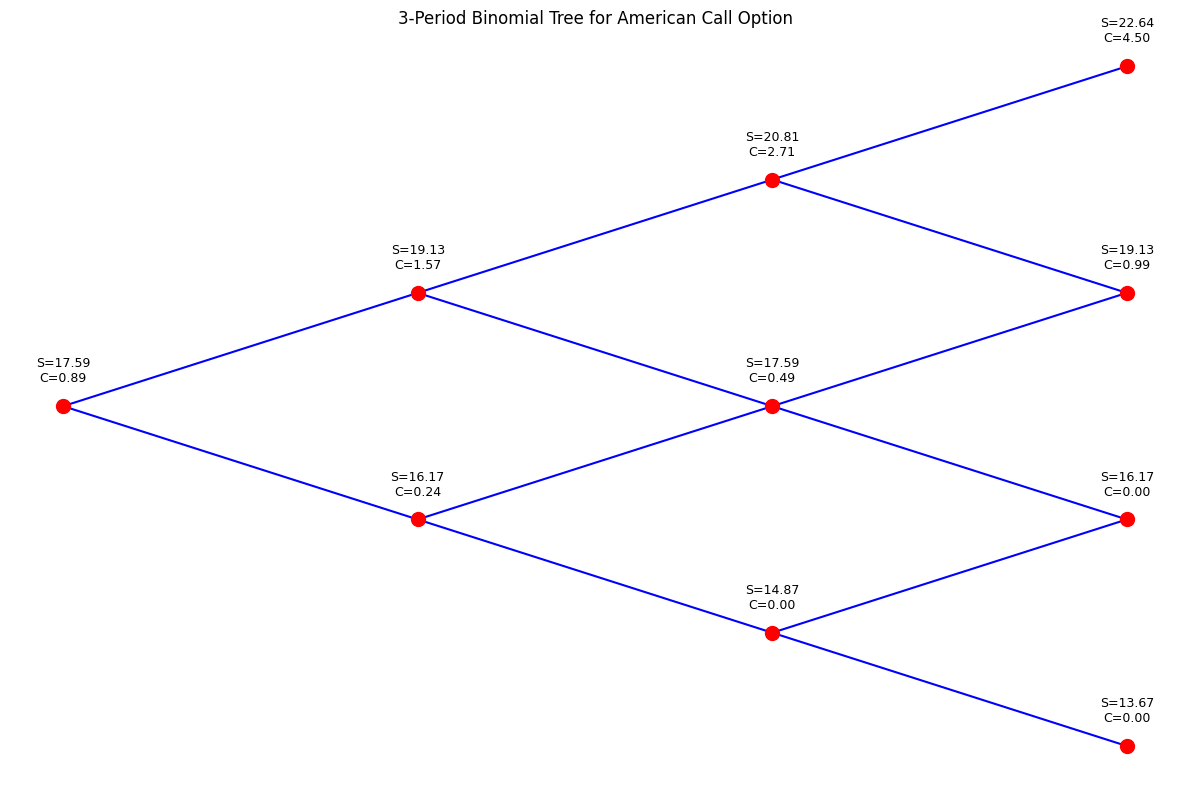


American call option price: 0.8930


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def binomial_tree_american_call_option(S, K, T, r, sigma, n=2):
    """
    American call option pricing using a binomial tree model.

    Parameters:
    S : Initial asset price
    K : Strike price
    T : Time to maturity (in years)
    r : Risk-free interest rate (annual)
    sigma : Asset volatility
    n : Number of periods (default = 2)

    Returns:
    call_price : Price of the American call option
    """
    # Calculate model parameters
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Create the asset price tree
    asset_prices = np.zeros((n+1, n+1))
    asset_prices[0, 0] = S

    for i in range(1, n+1):
        for j in range(i+1):
            if j == 0:
                asset_prices[j, i] = asset_prices[0, i-1] * d
            else:
                asset_prices[j, i] = asset_prices[j-1, i-1] * u

    # Calculate option values at maturity (n)
    option_prices = np.zeros((n+1, n+1))
    for j in range(n+1):
        option_prices[j, n] = max(0, asset_prices[j, n] - K)  # Payoff at maturity

    # Backward induction to calculate option price WITH early exercise (American option)
    for i in range(n-1, -1, -1):
        for j in range(i+1):
            # Value if held
            hold_value = np.exp(-r * dt) * (p * option_prices[j+1, i+1] + (1-p) * option_prices[j, i+1])
            # Value if exercised early
            exercise_value = max(0, asset_prices[j, i] - K)
            # Take maximum (American option feature)
            option_prices[j, i] = max(hold_value, exercise_value)

    # Display results
    print(f"Model parameters:")
    print(f"Up factor (u): {u:.4f}")
    print(f"Down factor (d): {d:.4f}")
    print(f"Risk-neutral probability (p): {p:.4f}")
    print("\nAsset price tree:")
    for j in range(n+1):
        for i in range(n+1):
            if i >= j:
                print(f"{asset_prices[j, i]:.2f}", end="\t")
        print()

    print("\nOption price tree:")
    for j in range(n+1):
        for i in range(n+1):
            if i >= j:
                print(f"{option_prices[j, i]:.2f}", end="\t")
        print()

    # Visualization of the tree (supports n=2 or n=3)
    if n == 2 or n == 3:
        plt.figure(figsize=(12, 8))

        if n == 2:
            # Node coordinates for 2-period tree
            x = [0, 1, 1, 2, 2, 2]
            y = [0, 1, -1, 2, 0, -2]

            # Draw edges
            plt.plot([x[0], x[1]], [y[0], y[1]], 'b-')
            plt.plot([x[0], x[2]], [y[0], y[2]], 'b-')
            plt.plot([x[1], x[3]], [y[1], y[3]], 'b-')
            plt.plot([x[1], x[4]], [y[1], y[4]], 'b-')
            plt.plot([x[2], x[4]], [y[2], y[4]], 'b-')
            plt.plot([x[2], x[5]], [y[2], y[5]], 'b-')

            # Draw nodes
            plt.plot(x, y, 'ro', markersize=10)

            # Add price values
            labels_asset = [
                f"S={S:.2f}\nC={option_prices[0, 0]:.2f}",
                f"S={asset_prices[1, 1]:.2f}\nC={option_prices[1, 1]:.2f}",
                f"S={asset_prices[0, 1]:.2f}\nC={option_prices[0, 1]:.2f}",
                f"S={asset_prices[2, 2]:.2f}\nC={option_prices[2, 2]:.2f}",
                f"S={asset_prices[1, 2]:.2f}\nC={option_prices[1, 2]:.2f}",
                f"S={asset_prices[0, 2]:.2f}\nC={option_prices[0, 2]:.2f}"
            ]

            plt.title(f"{n}-Period Binomial Tree for American Call Option")

        elif n == 3:
            # Node coordinates for 3-period tree
            x = [0, 1, 1, 2, 2, 2, 3, 3, 3, 3]
            y = [0, 1, -1, 2, 0, -2, 3, 1, -1, -3]

            # Draw edges
            plt.plot([x[0], x[1]], [y[0], y[1]], 'b-')
            plt.plot([x[0], x[2]], [y[0], y[2]], 'b-')
            plt.plot([x[1], x[3]], [y[1], y[3]], 'b-')
            plt.plot([x[1], x[4]], [y[1], y[4]], 'b-')
            plt.plot([x[2], x[4]], [y[2], y[4]], 'b-')
            plt.plot([x[2], x[5]], [y[2], y[5]], 'b-')
            plt.plot([x[3], x[6]], [y[3], y[6]], 'b-')
            plt.plot([x[3], x[7]], [y[3], y[7]], 'b-')
            plt.plot([x[4], x[7]], [y[4], y[7]], 'b-')
            plt.plot([x[4], x[8]], [y[4], y[8]], 'b-')
            plt.plot([x[5], x[8]], [y[5], y[8]], 'b-')
            plt.plot([x[5], x[9]], [y[5], y[9]], 'b-')

            # Draw nodes
            plt.plot(x, y, 'ro', markersize=10)

            # Add price values
            labels_asset = [
                f"S={S:.2f}\nC={option_prices[0, 0]:.2f}",
                f"S={asset_prices[1, 1]:.2f}\nC={option_prices[1, 1]:.2f}",
                f"S={asset_prices[0, 1]:.2f}\nC={option_prices[0, 1]:.2f}",
                f"S={asset_prices[2, 2]:.2f}\nC={option_prices[2, 2]:.2f}",
                f"S={asset_prices[1, 2]:.2f}\nC={option_prices[1, 2]:.2f}",
                f"S={asset_prices[0, 2]:.2f}\nC={option_prices[0, 2]:.2f}",
                f"S={asset_prices[3, 3]:.2f}\nC={option_prices[3, 3]:.2f}",
                f"S={asset_prices[2, 3]:.2f}\nC={option_prices[2, 3]:.2f}",
                f"S={asset_prices[1, 3]:.2f}\nC={option_prices[1, 3]:.2f}",
                f"S={asset_prices[0, 3]:.2f}\nC={option_prices[0, 3]:.2f}"
            ]

            plt.title(f"{n}-Period Binomial Tree for American Call Option")

        # Add labels to all nodes
        for i, label in enumerate(labels_asset):
            plt.annotate(label, (x[i], y[i]), xytext=(0, 15), textcoords='offset points',
                        ha='center', va='bottom', fontsize=9)

        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return option_prices[0, 0]


call_price = binomial_tree_american_call_option(S, K, T, r, sigma, n=3)
print(f"\nAmerican call option price: {call_price:.4f}")

📈 **Interpretation: American Call Option Pricing**

The price of the **American call option** estimated using the **binomial tree model** is **\$0.8930**,  
whereas the **European call option** price obtained via the **Black-Scholes model** is **\$0.8292**.

🧾 This difference highlights a key point:  
> The American option is slightly **more valuable** because it allows for **early exercise**.  
The **additional flexibility** embedded in the American option results in a **higher premium**.



In [ ]:
from math import comb

def prob_ITM_and_required_ups(S, K, u, d, p, n):
    """
    Computes the probability that the option expires in-the-money (S_T > K)
    and the minimum number of up moves required to end up ITM.

    Parameters:
    - S : initial stock price
    - K : strike price
    - u : up factor
    - d : down factor
    - p : risk-neutral probability
    - n : number of steps

    Returns:
    - total_prob_ITM : total probability of finishing in-the-money
    - min_ups_required : minimum number of up moves needed to end ITM
    """
    total_prob_ITM = 0
    min_ups_required = None

    for k in range(n + 1):  # k = number of up moves
        S_T = S * (u ** k) * (d ** (n - k))
        if S_T > K:
            prob = comb(n, k) * (p ** k) * ((1 - p) ** (n - k))
            total_prob_ITM += prob
            if min_ups_required is None:
                min_ups_required = k  # first time S_T > K, it's the minimum up moves

    return total_prob_ITM, min_ups_required


# Parameters
n=3
u = np.exp(sigma * np.sqrt(T / n))
d = 1 / u
p = (np.exp(r * (T / n)) - d) / (u - d)
prob_ITM, min_ups = prob_ITM_and_required_ups(S, K, u, d, p, n=3)

# Results
print(f"\n✅ Probability the option expires in the money (S_T > K): {prob_ITM:.4f}")
print(f"📈 Minimum number of up moves needed to end in the money: {min_ups}")



✅ Probability the option expires in the money (S_T > K): 0.4869
📈 Minimum number of up moves needed to end in the money: 2


📊 **Interpretation**  
There is a **48.69% chance** the option will expire **in the money**, requiring **at least 2 upward moves** in the binomial tree to reach profitability at maturity.


# Theta Hedging

**Butterfly Position**  
A butterfly spread is an **options strategy** combining **three strike prices**: it involves buying 1 call at a lower strike (K–1), selling 2 calls at the middle strike (K), and buying 1 call at a higher strike (K+1).  

This position **profits if the underlying stays close to the middle strike (K)**, and its **theta is typically positive**, meaning the portfolio **benefits from time decay** as expiration approaches.

However, to stabilize the portfolio’s sensitivity to time decay, we may hedge this **positive theta** by selling an option with **negative theta** to achieve **theta-neutrality**.


In [ ]:
# --- Step 1: Define butterfly strikes ---
K_lower = K - 1
K_upper = K + 1

# Compute thetas for butterfly position (long K-1 and K+1, short 2x K)
theta_K_lower = black_scholes_greeks_call(S, K_lower, T, r, sigma)["Theta (daily)"]
theta_K = call_greeks["Theta (daily)"]
theta_K_upper = black_scholes_greeks_call(S, K_upper, T, r, sigma)["Theta (daily)"]

# Total theta of the butterfly position
theta_butterfly = theta_K_lower - 2 * theta_K + theta_K_upper

# --- Step 2: Choose hedge option (e.g. K+2) ---
K_hedge = K + 2
theta_hedge = black_scholes_greeks_call(S, K_hedge, T, r, sigma)["Theta (daily)"]

# --- Step 3: Compute number of hedge contracts to offset theta ---
n_hedge_theta = theta_butterfly / theta_hedge

# Display result
print("🕓 Theta-Neutral Hedge for Butterfly Position")
print(f"Theta of Butterfly Position: {theta_butterfly:.5f}")
print(f"Theta of Hedge Option (Strike = {K_hedge}): {theta_hedge:.5f}")
print(f"➡ Number of hedge contracts to sell: {-n_hedge_theta:.2f}")


🕓 Theta-Neutral Hedge for Butterfly Position
Theta of Butterfly Position: 0.00075
Theta of Hedge Option (Strike = 20.142460293240017): -0.00425
➡ Number of hedge contracts to sell: 0.18


🕰️ **Theta-Neutral Hedge for Butterfly Position**  
The butterfly position has a small positive Theta (**+0.00075**), meaning it slightly benefits from the passage of time.  
To fully neutralize this exposure, we would need to **sell 0.18 call contracts**, which is **very close to zero**.  
📌 This suggests the portfolio is **already nearly insensitive to time decay**, and **no significant adjustment** is required to hedge Theta.


# Conclusion

In this project, we analyzed option pricing and hedging strategies on **Puig** using models such as Black-Scholes, Binomial Trees, and Local Volatility. We applied Greek-based risk management (Delta, Gamma, Vega, Theta) and explored Monte Carlo simulations for more robust pricing insights.

Notably, our **Protective Put strategy** proved relevant: while the underlying price of Puig ranged between **€17–18** in mid-March, it dropped to **€15.06 by April 4**, illustrating how the strategy would have effectively **protected against downside risk**.

That said, **Puig's recent IPO** and its position in the **luxury sector** may imply **lower option liquidity**, which could limit perfect hedging execution in real markets.


# Notes

- We used DeepResearch AI to generate a detailed **financial report on Puig and the luxury sector** . This report contains various insights, including key financial data, market trends, and future growth perspectives. By analyzing this information, we were able to determine the most suitable trading strategy to implement. You can view the report at the following link: https://docs.google.com/document/d/1tDQXp2zubl7_QhZfd4ic02TdKq8JQ1t3LgiqEM_gFB0/edit?usp=sharing

# Bibliography

- Alexander, C. (2008). Market Risk Analysis, Volume I: Quantitative Methods in Finance. Wiley.
- Le Moign, Caroline, et Ari Ezra. 2021. Caractéristiques du marché des options sur actions françaises. Autorité des marchés financiers.
- Petrov, D. (2025). Risk Management [Course notes].
- Shreve, S. E. (2004). Stochastic Calculus for Finance II: Continuous-Time Models. Springer Finance.



